In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import wasserstein_distance
from ot import emd2
import glob
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding, Isomap
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Cropping2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
## TEST FOR GPU AVAILABILITY

tf.config.list_physical_devices('GPU')

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Images

In [3]:
filenames = glob.glob('data/img/image_0_*.png')
maxx = np.max([len(f) for f in filenames])
for i in np.arange(len(filenames)):
    insert_str = (maxx - len(filenames[i])) * '0'
    filenames[i] = filenames[i][:17] + insert_str + filenames[i][17:]
    filenames[i] = filenames[i][17:21]
filenames = np.array(filenames).astype('int')
indxs_sorted = np.argsort(filenames)
filenames_original_sorted = np.array(glob.glob('data/img/image_0_*.png'))[indxs_sorted]

In [4]:
## LOAD IMAGES

imgs = np.array([plt.imread(img) for img in filenames_original_sorted])

In [5]:
## RESHAPE IMAGES AND PREPARE FOR TRAINING
imgs_crop = imgs[980:2210,:-4,:-4]  #927:2312
data = imgs_crop.reshape((imgs_crop.shape[0], imgs_crop.shape[1], imgs_crop.shape[2],1))
data.shape

(1230, 476, 636, 1)

In [6]:
#indxs = np.random.choice(np.arange(data.shape[0]), 1000, replace=False)
#data = data[indxs]
print(data.shape)

(1230, 476, 636, 1)


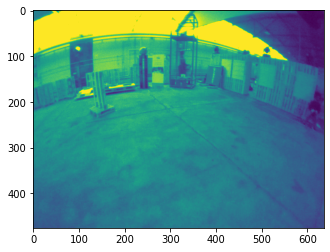

In [7]:
plt.imshow(data[0])

## Drone trajectory

In [8]:
## LOAD DRONE'S SPATIAL TRAJECTORY IN 3D

ground_truth = np.loadtxt('data/groundtruth.txt',comments='#',delimiter=' ',skiprows=1)
ground_truth.shape

(24750, 8)

In [9]:
## GET THE CLOSEST 3D POSITION AT THE TIME OF EACH TAKEN IMAGE FROM THE GROUND TRUTH DATA

times_imgs = np.loadtxt('data/left_images.txt', comments='#', delimiter=' ', skiprows=1, usecols=(1))

pos = ground_truth[:, 1:4]
times_pos = ground_truth[:,0]

pos_imgs = []
for t_imgs in times_imgs:
    indx = np.searchsorted(times_pos, t_imgs, side='right')  # finds the index of the first timestamp that is <= than t.
    pos_imgs.append( pos[indx-1,:] )
pos_imgs = np.array(pos_imgs)[980:2210,:2]

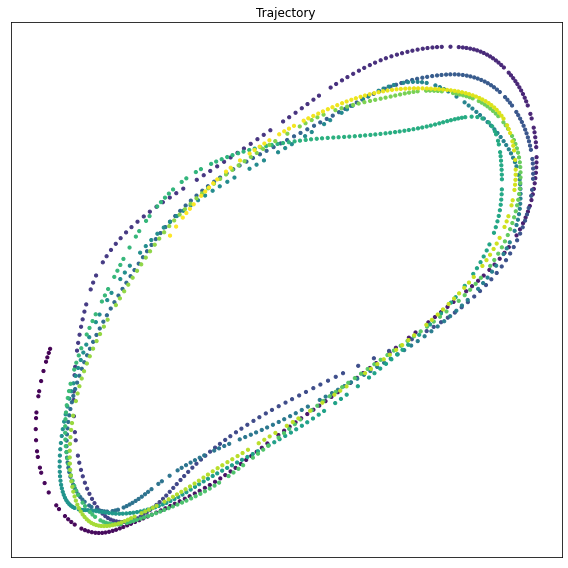

In [10]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(8,8))

plt.title('Trajectory')

x2 = pos_imgs[:,0]
y2 = pos_imgs[:,1]
#z2 = pos_imgs[:,2]

#plt.scatter(x2, y2, z2, marker='o', color=plt.cm.viridis(np.linspace(0,1, x2.shape[0])), s=10)
plt.scatter(x2, y2, marker='o', color=plt.cm.viridis(np.linspace(0,1, x2.shape[0])), s=10)

plt.grid(True)

plt.xticks([])
plt.yticks([])
#ax2.set_zticklabels([])

plt.tight_layout()
plt.show()

## Autoencoder

In [11]:
## BUILD CONVOLUTIONAL AUTOENCODER

def build_model(img_shape=(476,636,1), hidden_layer_size=200):
    
    input_img = Input(shape=img_shape)
    filter_size = (3, 3)
    pooling_size = (2, 2)

    x = Conv2D(16, filter_size, activation='relu', padding='same')(input_img)
    x = MaxPooling2D(pooling_size, padding='same')(x)
    x = Conv2D(16, filter_size, activation='relu', padding='same')(x)
    x = MaxPooling2D(pooling_size, padding='same')(x)
    x = Conv2D(16, filter_size, activation='relu', padding='same')(x)
    x = MaxPooling2D(pooling_size, padding='same')(x)
    x = Conv2D(32, filter_size, activation='relu', padding='same')(x)
    x = MaxPooling2D(pooling_size, padding='same')(x)
    x = Conv2D(32, filter_size, activation='relu', padding='same')(x)
    x = MaxPooling2D(pooling_size, padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(hidden_layer_size, activation="relu", name='hidden')(x)
    x = Dense(15*20*32)(x)
    x = Reshape((15, 20, 32))(x)
    
    x = Conv2D(32, filter_size, activation='relu', padding='same')(x)
    x = UpSampling2D(pooling_size)(x)
    x = Conv2D(32, filter_size, activation='relu', padding='same')(x)
    x = UpSampling2D(pooling_size)(x)
    x = Conv2D(16, filter_size, activation='relu', padding='same')(x)
    x = UpSampling2D(pooling_size)(x)
    x = Conv2D(16, filter_size, activation='relu', padding='same')(x)
    x = UpSampling2D(pooling_size)(x)
    x = Conv2D(16, filter_size, activation='relu')(x)
    x = UpSampling2D(pooling_size)(x)
    x = Conv2D(1, filter_size, activation='relu', padding='same')(x)

    autoencoder = Model(input_img, x)
    
    optimizer = RMSprop(lr=0.001)
    autoencoder.compile(loss='mse', optimizer=optimizer)
    
    #autoencoder.summary()
    
    return autoencoder

In [12]:
hidden_layer_size = 100
model = build_model(hidden_layer_size=hidden_layer_size)

In [37]:
compressed_array = []
runs_array = []

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        m = Model(inputs=model.inputs, outputs=model.get_layer('hidden').output)
        compressed = m.predict(data)
        compressed_array.append(compressed)

In [39]:
## TRAIN MODEL

history = model.fit(data, data, epochs=100, batch_size=32, verbose=1, callbacks=[MyCallback()])

Epoch 1/100
39/39 [==============================] - 37s 508ms/step - loss: 2.3316
Epoch 2/100
39/39 [==============================] - 21s 466ms/step - loss: 0.0294
Epoch 3/100
39/39 [==============================] - 21s 468ms/step - loss: 0.0360
Epoch 4/100
39/39 [==============================] - 26s 470ms/step - loss: 0.0387
Epoch 5/100
39/39 [==============================] - 23s 472ms/step - loss: 0.0303
Epoch 6/100
39/39 [==============================] - 22s 472ms/step - loss: 0.0276
Epoch 7/100
39/39 [==============================] - 23s 475ms/step - loss: 0.0253
Epoch 8/100
39/39 [==============================] - 22s 475ms/step - loss: 0.0232
Epoch 9/100
39/39 [==============================] - 22s 479ms/step - loss: 0.0214
Epoch 10/100
39/39 [==============================] - 22s 475ms/step - loss: 0.0195
Epoch 11/100
39/39 [==============================] - 27s 480ms/step - loss: 0.0169
Epoch 12/100
39/39 [==============================] - 22s 476ms/step - loss: 0.0156
E

Text(0.5, 0, 'epoch')

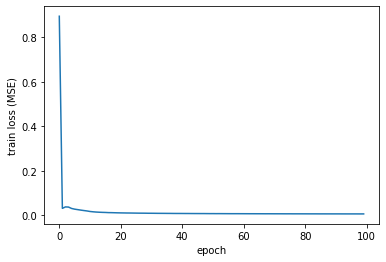

In [40]:
plt.plot(history.history['loss'])
plt.ylabel('train loss (MSE)')
plt.xlabel('epoch')

In [41]:
m = Model(inputs=model.inputs, outputs=model.get_layer('hidden').output)
compressed = m.predict(data)
compressed_array.append(compressed)

In [44]:
np.array(compressed_array).shape

(101, 1230, 100)

In [45]:
# SAVE MODEL
#model.save('data/AE_drone_hidden100.h5')

In [13]:
# LOAD MODEL
model = load_model('data/AE_drone_hidden100.h5')

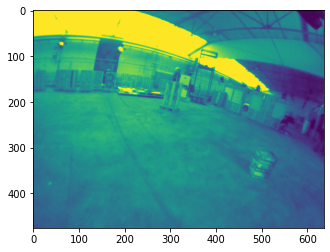

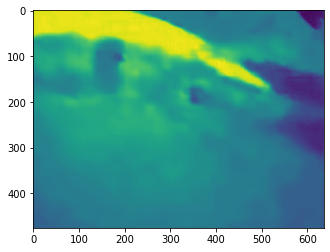

In [14]:
# RECONSTRUCTION EXAMPLES AFTER TRAINING

indx = 405

original = data[indx]
plt.imshow(original)
plt.show()

reconstructed = model.predict(np.expand_dims(original, axis=0))[0]
plt.imshow(reconstructed)
plt.show()

In [15]:
## EXTRACT HIDDEN LAYER RESPONSE

m = Model(inputs=model.inputs, outputs=model.get_layer('hidden').output)
compressed = m.predict(data)

In [16]:
compressed.shape

(1230, 100)

## Analysis

### Latent space

In [163]:
## EXTRACT LATENT MANIFOLD FROM HIDDEN LAYER RESPONSES

from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding, Isomap

embedding = MDS(n_components=2)
#embedding = TSNE(n_components=2)
#embedding = Isomap(n_components=2)
reduced = embedding.fit_transform(compressed)

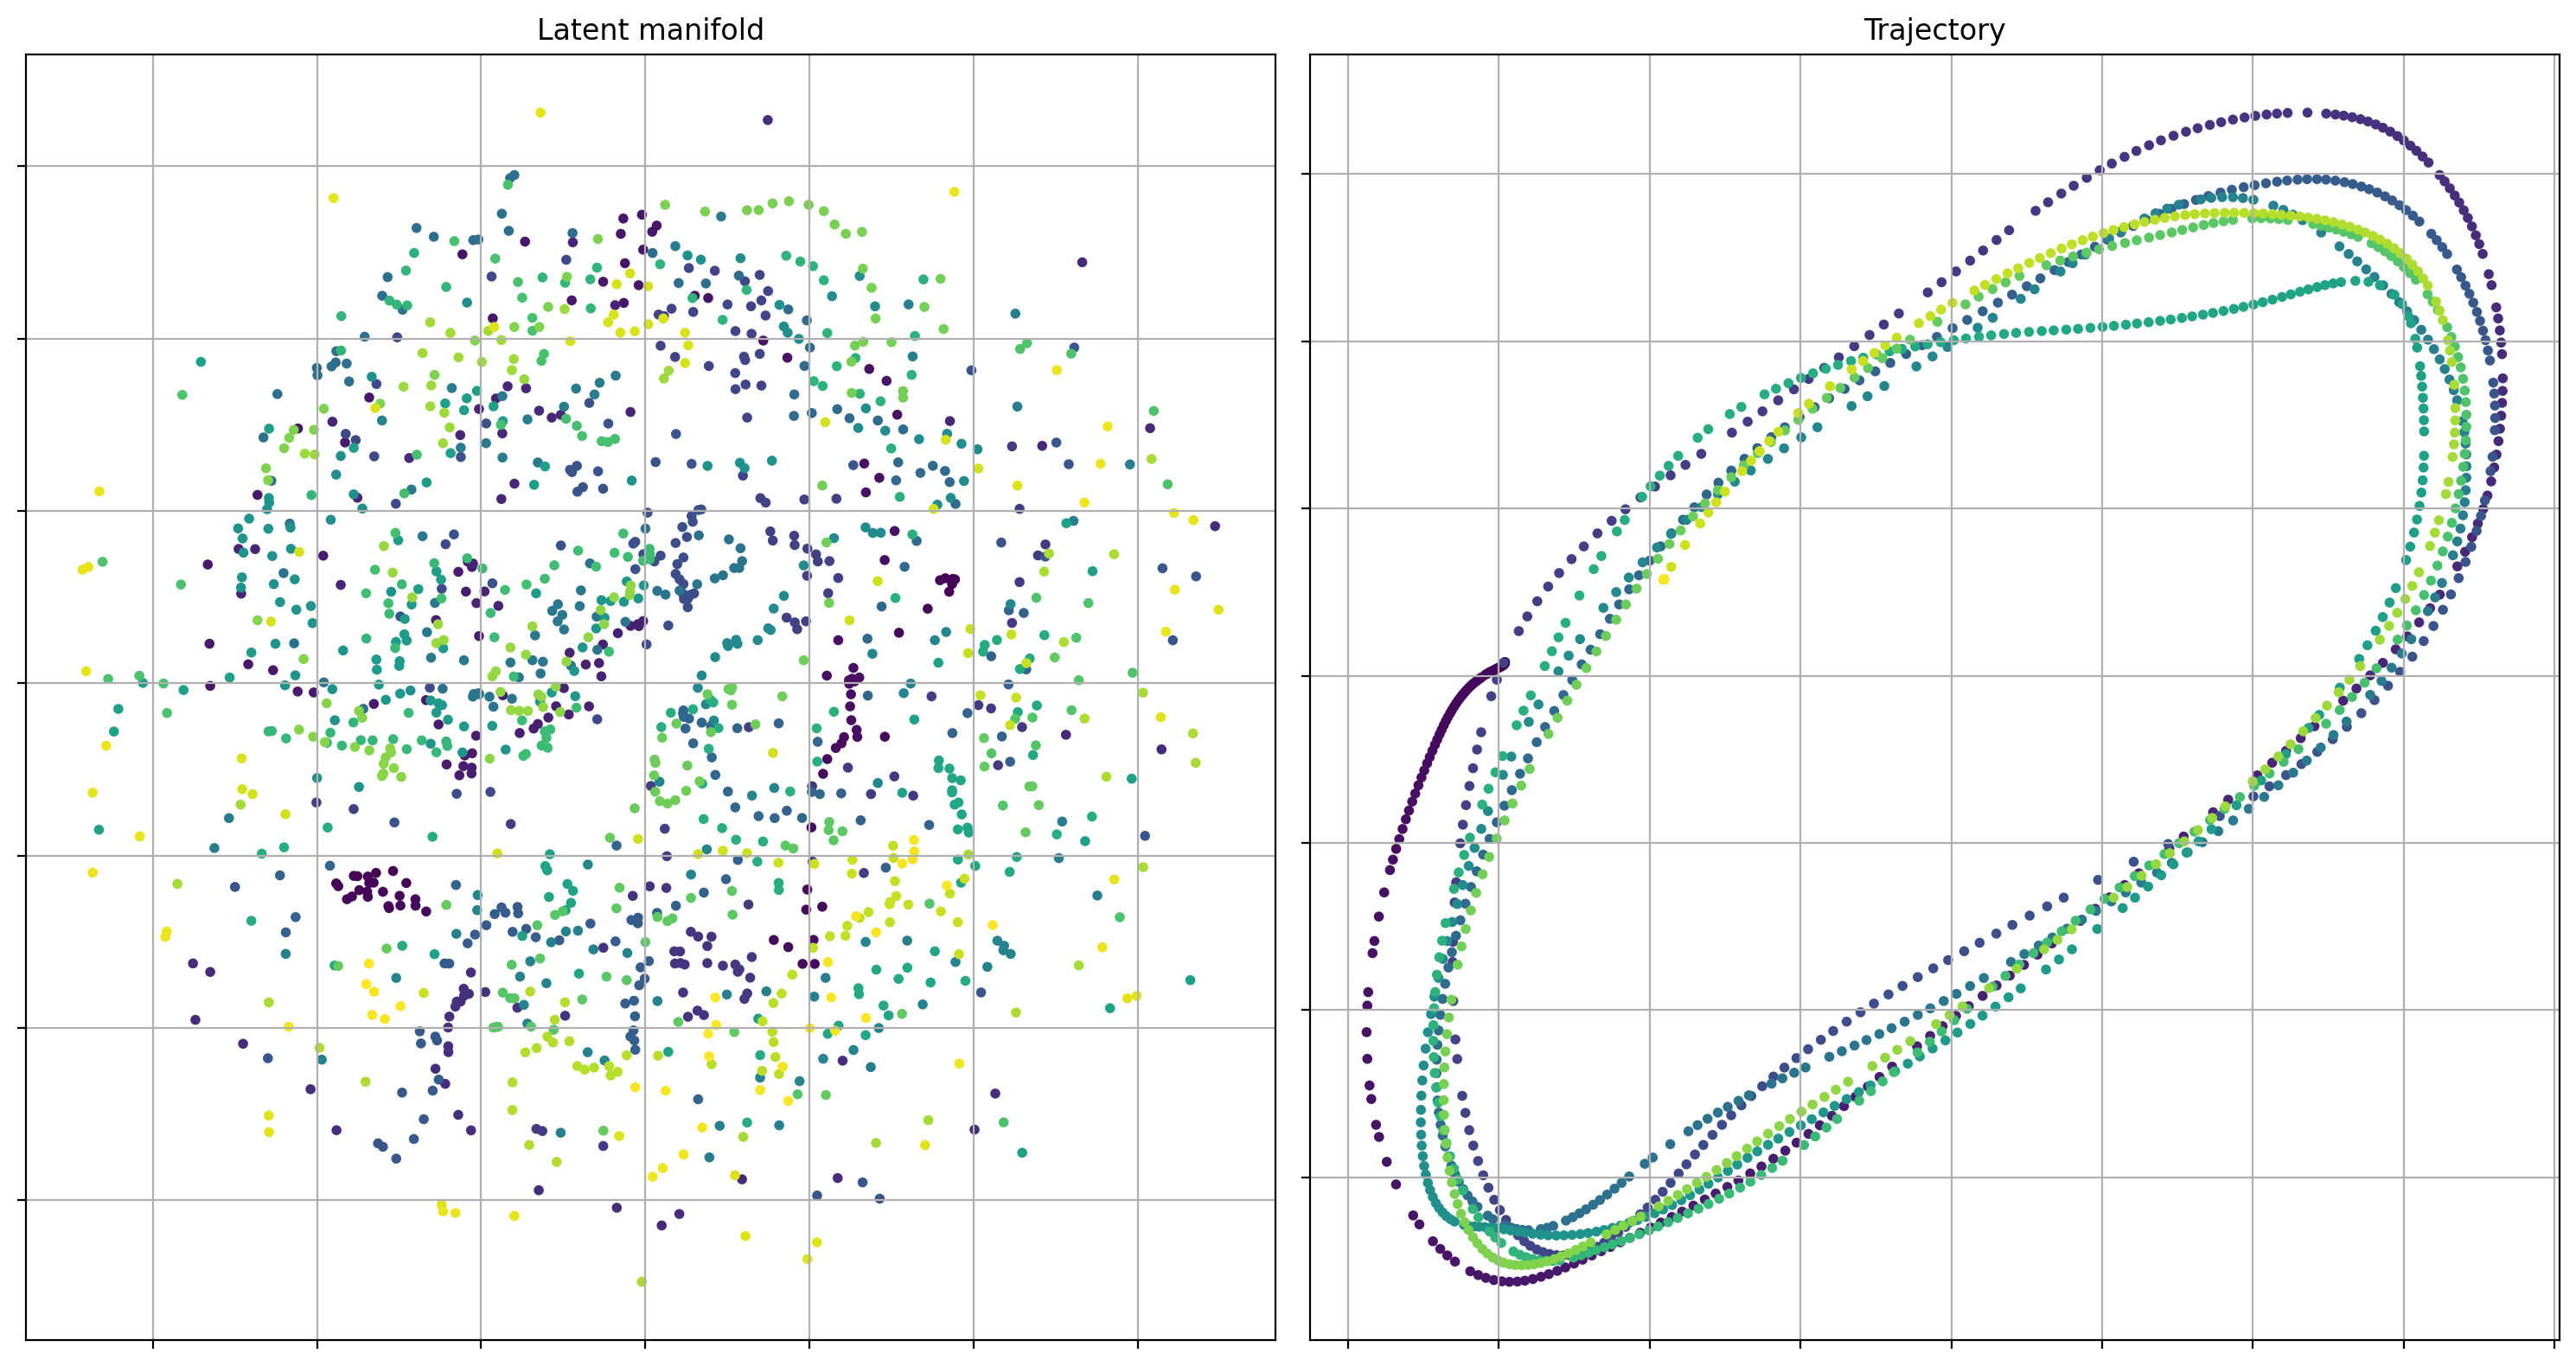

In [164]:
from mpl_toolkits.mplot3d import Axes3D

## HIDDEN MANIFOLD FIGURE

title1 = 'Latent manifold'

fig = plt.figure(figsize=(15,8), dpi=200)
    
ax1 = fig.add_subplot(1,2,1)#, projection='3d')

ax1.set_title(title1)

x1 = reduced[:,0]
y1 = reduced[:,1]
#z1 = reduced[:,2]

#ax1.scatter(x1, y1, z1, marker='o', color=plt.cm.viridis(np.linspace(0,1, x1.shape[0])), s=10)
ax1.scatter(x1, y1, marker='o', color=plt.cm.viridis(np.linspace(0,1, x1.shape[0])), s=10)

ax1.grid(True)

ax1.set_xticklabels([])
ax1.set_yticklabels([])
#ax1.set_zticklabels([])

#lgnd = plt.legend()

#lgnd.legendHandles[0]._sizes = [20]
#lgnd.legendHandles[1]._sizes = [20]



## SPATIAL TRAJECTORY FIGURE

title2 = 'Trajectory'
    
ax2 = fig.add_subplot(1,2,2)#, projection='3d')

ax2.set_title(title2)

'''
x2 = ground_truth[:,2]
y2 = ground_truth[:,3]
z2 = ground_truth[:,4]
'''
x2 = pos_imgs[:,0]
y2 = pos_imgs[:,1]
#z2 = pos_imgs[:,2]

#ax2.scatter(x2, y2, z2, marker='o', color=plt.cm.viridis(np.linspace(0,1, x2.shape[0])), s=10)
ax2.scatter(x2, y2, marker='o', color=plt.cm.viridis(np.linspace(0,1, x2.shape[0])), s=10)

ax2.grid(True)

ax2.set_xticklabels([])
ax2.set_yticklabels([])
#ax2.set_zticklabels([])

#lgnd = plt.legend()

#lgnd.legendHandles[0]._sizes = [20]
#lgnd.legendHandles[1]._sizes = [20]

fig.tight_layout()
#plt.savefig('manifolds.png', bbox_inches='tight', dpi=600)
plt.show()

In [160]:
reduced.shape, pos_imgs.shape

((2420, 2), (2420, 2))

### Linear regression

In [17]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

linear_model.fit(compressed, pos_imgs)

linear_model.score(compressed, pos_imgs)

0.8087321269964934

In [18]:
print( 'Predicted: '+str( linear_model.predict(compressed)[0] ) )
print( 'True: '+str( pos_imgs[0] ) )

Predicted: [ 8.295172  -1.7977389]
True: [ 5.84694996 -1.9534085 ]


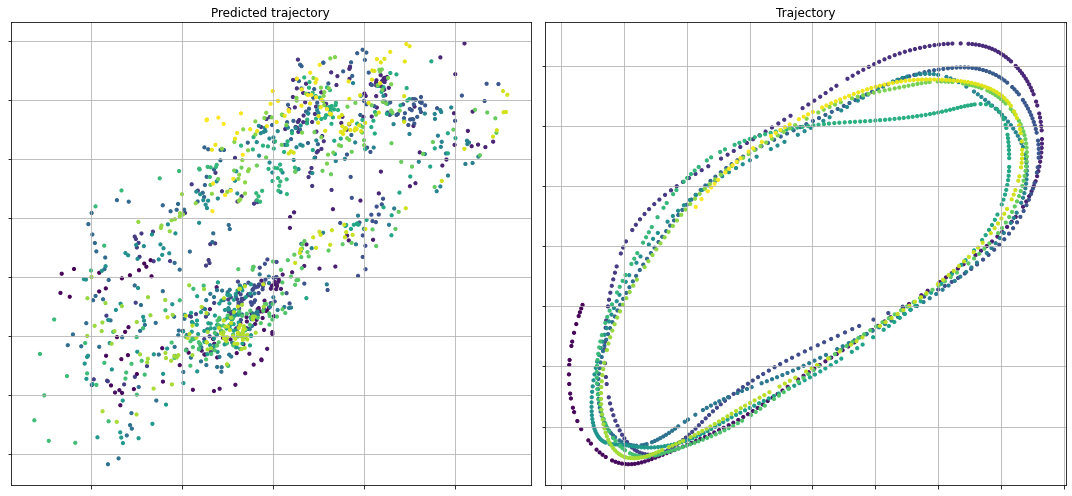

In [19]:
from mpl_toolkits.mplot3d import Axes3D

## HIDDEN MANIFOLD FIGURE

title1 = 'Predicted trajectory'

fig = plt.figure(figsize=(15,7))
    
ax1 = fig.add_subplot(1,2,1)#, projection='3d')

ax1.set_title(title1)

predicted_traj = linear_model.predict(compressed)
x1 = predicted_traj[:,0]
y1 = predicted_traj[:,1]
#z1 = reduced[:,2]

#ax1.scatter(x1, y1, z1, marker='o', color=plt.cm.viridis(np.linspace(0,1, x1.shape[0])), s=10)
ax1.scatter(x1, y1, marker='o', color=plt.cm.viridis(np.linspace(0,1, x1.shape[0])), s=10)

ax1.grid(True)

ax1.set_xticklabels([])
ax1.set_yticklabels([])
#ax1.set_zticklabels([])

#lgnd = plt.legend()

#lgnd.legendHandles[0]._sizes = [20]
#lgnd.legendHandles[1]._sizes = [20]



## SPATIAL TRAJECTORY FIGURE

title2 = 'Trajectory'
    
ax2 = fig.add_subplot(1,2,2)#, projection='3d')

ax2.set_title(title2)

'''
x2 = ground_truth[:,2]
y2 = ground_truth[:,3]
z2 = ground_truth[:,4]
'''
x2 = pos_imgs[:,0]
y2 = pos_imgs[:,1]
#z2 = pos_imgs[:,2]

#ax2.scatter(x2, y2, z2, marker='o', color=plt.cm.viridis(np.linspace(0,1, x2.shape[0])), s=10)
ax2.scatter(x2, y2, marker='o', color=plt.cm.viridis(np.linspace(0,1, x2.shape[0])), s=10)

ax2.grid(True)

ax2.set_xticklabels([])
ax2.set_yticklabels([])
#ax2.set_zticklabels([])

#lgnd = plt.legend()

#lgnd.legendHandles[0]._sizes = [20]
#lgnd.legendHandles[1]._sizes = [20]

fig.tight_layout()
#plt.savefig('manifolds.png', bbox_inches='tight', dpi=600)
plt.show()

In [20]:
r = np.corrcoef( predicted_traj.astype(np.float64).flatten(), pos_imgs.astype(np.float64).flatten() )[0][1]
print(r)

0.9643953750428843


In [182]:
baseline_scores_regression = []

for i in range(100):
    untrained_model = build_model()
    untrained_m = Model(inputs=untrained_model.inputs, outputs=untrained_model.get_layer('hidden').output)
    untrained_compressed = untrained_m.predict(data)
    
    linear_model = LinearRegression()
    linear_model.fit(untrained_compressed, pos_imgs)
    score = linear_model.score(untrained_compressed, pos_imgs)
    
    baseline_scores_regression.append(score)

(array([13., 22., 33., 18., 14.]),
 array([0.77422178, 0.79032188, 0.80642198, 0.82252209, 0.83862219,
        0.85472229]),
 <BarContainer object of 5 artists>)

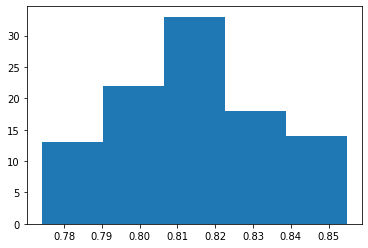

In [184]:
plt.hist(baseline_scores_regression, bins=5)

In [ ]:
for i in range(1, hidden_layer_size+1):
    pass

### Place fields

In [21]:
def ratemap_filtered_Gaussian(ratemap):
    '''
    Takes a ratemap and adds Gaussians filters to make it more spatially smooth.
    '''
    new_ratemap = gaussian_filter(ratemap, 3)   
    return new_ratemap

In [22]:
def generate_ratemaps(compressed):
    '''
    Create ratemaps from hidden layer activity and position trajectory of drone.
    '''
    # Normalize position with respect to grid resolution to convert position to ratemap indices
    res = 49

    pos_imgs_norm = np.copy(pos_imgs)

    pos_imgs_norm[:,0] = (pos_imgs_norm[:,0] - np.min(pos_imgs_norm[:,0]))
    pos_imgs_norm[:,0] = pos_imgs_norm[:,0]/np.max(pos_imgs_norm[:,0])
    pos_imgs_norm[:,0] = pos_imgs_norm[:,0]*res

    pos_imgs_norm[:,1] = pos_imgs_norm[:,1] + np.abs(np.min(pos_imgs_norm[:,1]))
    pos_imgs_norm[:,1] = pos_imgs_norm[:,1]/np.max(pos_imgs_norm[:,1])
    pos_imgs_norm[:,1] = pos_imgs_norm[:,1]*res

    pos_imgs_norm = pos_imgs_norm.astype(int)
    
    # Add activation values to each cell in the ratemap and adds Gaussian smoothing
    ratemaps = np.zeros((hidden_layer_size, res+1, res+1))
    for i in range(hidden_layer_size):
        for ii, c in enumerate(compressed[:,i]):
            indx_x = pos_imgs_norm[ii,0]
            indx_y = pos_imgs_norm[ii,1]
            ratemaps[i, indx_x, indx_y] += c
        if np.any(ratemaps[i]):
            if np.min(ratemaps[i]) < 0:
                ratemaps[i][ratemaps[i].nonzero()] = ratemaps[i][ratemaps[i].nonzero()] + np.abs(np.min(ratemaps[i]))
            ratemaps[i] = ratemaps[i]/np.max(ratemaps[i])
            ratemaps[i] = ratemap_filtered_Gaussian(ratemaps[i])
            ratemaps[i] = ratemaps[i]/np.max(ratemaps[i])
        
    return ratemaps

In [23]:
ratemaps_all = generate_ratemaps(compressed)

In [25]:
plt.figure(figsize=(20,20), dpi=600)
for i in range(hidden_layer_size):
    plt.subplot(10, 10, i+1)
    plt.imshow(ratemaps_all[i], cmap='hot', origin='lower')
    plt.axis('off')
plt.tight_layout()
plt.show()

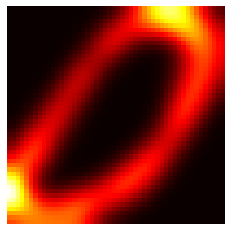

In [26]:
plt.imshow(np.sum(ratemaps_all,axis=0), cmap='hot', origin='lower')
plt.axis('off')
plt.show()

In [27]:
def get_number_of_place_fields(c_ratemap):
    '''
    Runs a simple clustering algorithm to determine the number of place fields in a given ratemap.
    '''
    ratemap = c_ratemap.copy()
    
    gauss_kernel_sigma      = 9  # px
    active_pixels_threshold = .2 # 20 percent
    cluster_min             = 200/2
    cluster_max             = 2500/2
    
    ratemap[ ratemap <  ratemap.max()*active_pixels_threshold ] = 0
    ratemap[ ratemap >= ratemap.max()*active_pixels_threshold ] = 1


    visited_matrix  = np.zeros_like(ratemap)


    ratemap[ ratemap <  ratemap.max()*active_pixels_threshold ] = 0
    ratemap[ ratemap >= ratemap.max()*active_pixels_threshold ] = 1

    visited_matrix  = np.zeros_like(ratemap)

    
    ## First pass of clustering
    clusterd_matrix = np.zeros_like(ratemap)
    current_cluster = 1

    #go through every bin in the ratemap
    for yy in range(1,ratemap.shape[0]-1):
        for xx in range(1,ratemap.shape[1]-1):

            if ratemap[  yy, xx ] == 1:

                ## go through every bin around this bin
                for ty in range(-1,2):
                    for tx in range(-1,2):

                        if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                            clusterd_matrix[ yy,xx ] = clusterd_matrix[ yy+ty, xx+tx ]

                if clusterd_matrix[ yy, xx ] == 0:
                    current_cluster += 1
                    clusterd_matrix[ yy, xx ] = current_cluster

                    
    ## Refine clustering: neighbour bins to same cluster number
    for yy in range(1,clusterd_matrix.shape[0]-1):
        for xx in range(1,clusterd_matrix.shape[1]-1):


            if clusterd_matrix[  yy, xx ] != 0:

                ## go through every bin around this bin
                for ty in range(-1,2):
                    for tx in range(-1,2):

                        if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                            if clusterd_matrix[ yy+ty, xx+tx ] != clusterd_matrix[  yy, xx ]:
                                clusterd_matrix[ yy+ty, xx+tx ] = clusterd_matrix[  yy, xx ]

                                
    ## Quantify number of place fields
    clusters_labels = np.delete(np.unique(clusterd_matrix),   np.where(  np.unique(clusterd_matrix) ==0 ) )

    n_place_fields_counter = 0

    for k in range(clusters_labels.size):

        n_bins = np.where(clusterd_matrix == clusters_labels[k] )[0].size

        if cluster_min <= n_bins <= cluster_max:

            n_place_fields_counter += 1

                 
    return n_place_fields_counter

In [28]:
# Get the place field histogram for the hidden layer
num_fields = []
for i in range(hidden_layer_size):
    num_fields.append( get_number_of_place_fields(ratemaps_all[i]) )
place_field_counts = np.histogram(num_fields, bins=np.max(num_fields)+1, density=True)[0]

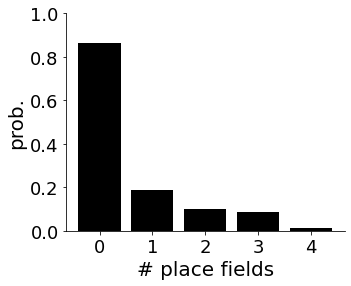

In [30]:
plt.figure(figsize=(5,4))
plt.bar(np.arange(np.max(num_fields)+1), place_field_counts, color='black', alpha=1)
plt.xlabel('# place fields', fontsize=20)
plt.ylabel('prob.', fontsize=20)
plt.yticks(np.linspace(0,1,6), np.linspace(0,1,6).round(1), fontsize=18)
plt.xticks(np.linspace(0, np.max(num_fields), np.max(num_fields)+1, dtype=int), np.linspace(0, np.max(num_fields), np.max(num_fields)+1, dtype=int), fontsize=18)
plt.ylim(0,1)
sns.despine()
plt.show()

In [31]:
# Relationship between spatial distance and distance in latent space representations.
n_images = compressed.shape[0]
spatial_dist = []
image_dist = []
latent_dist = []
for i in range(1000):
    indx_1, indx_2 = np.random.choice(a=range(n_images), size=2, replace=False)
    
    sp_dist = np.sqrt(np.sum((pos_imgs[indx_1] - pos_imgs[indx_2])**2))
    spatial_dist.append(sp_dist)
    
    im_dist = wasserstein_distance(data[indx_1].flatten(), data[indx_2].flatten())
    image_dist.append(im_dist)
    
    lt_dist = np.sqrt(np.sum((compressed[indx_1] - compressed[indx_2])**2))
    latent_dist.append(lt_dist)

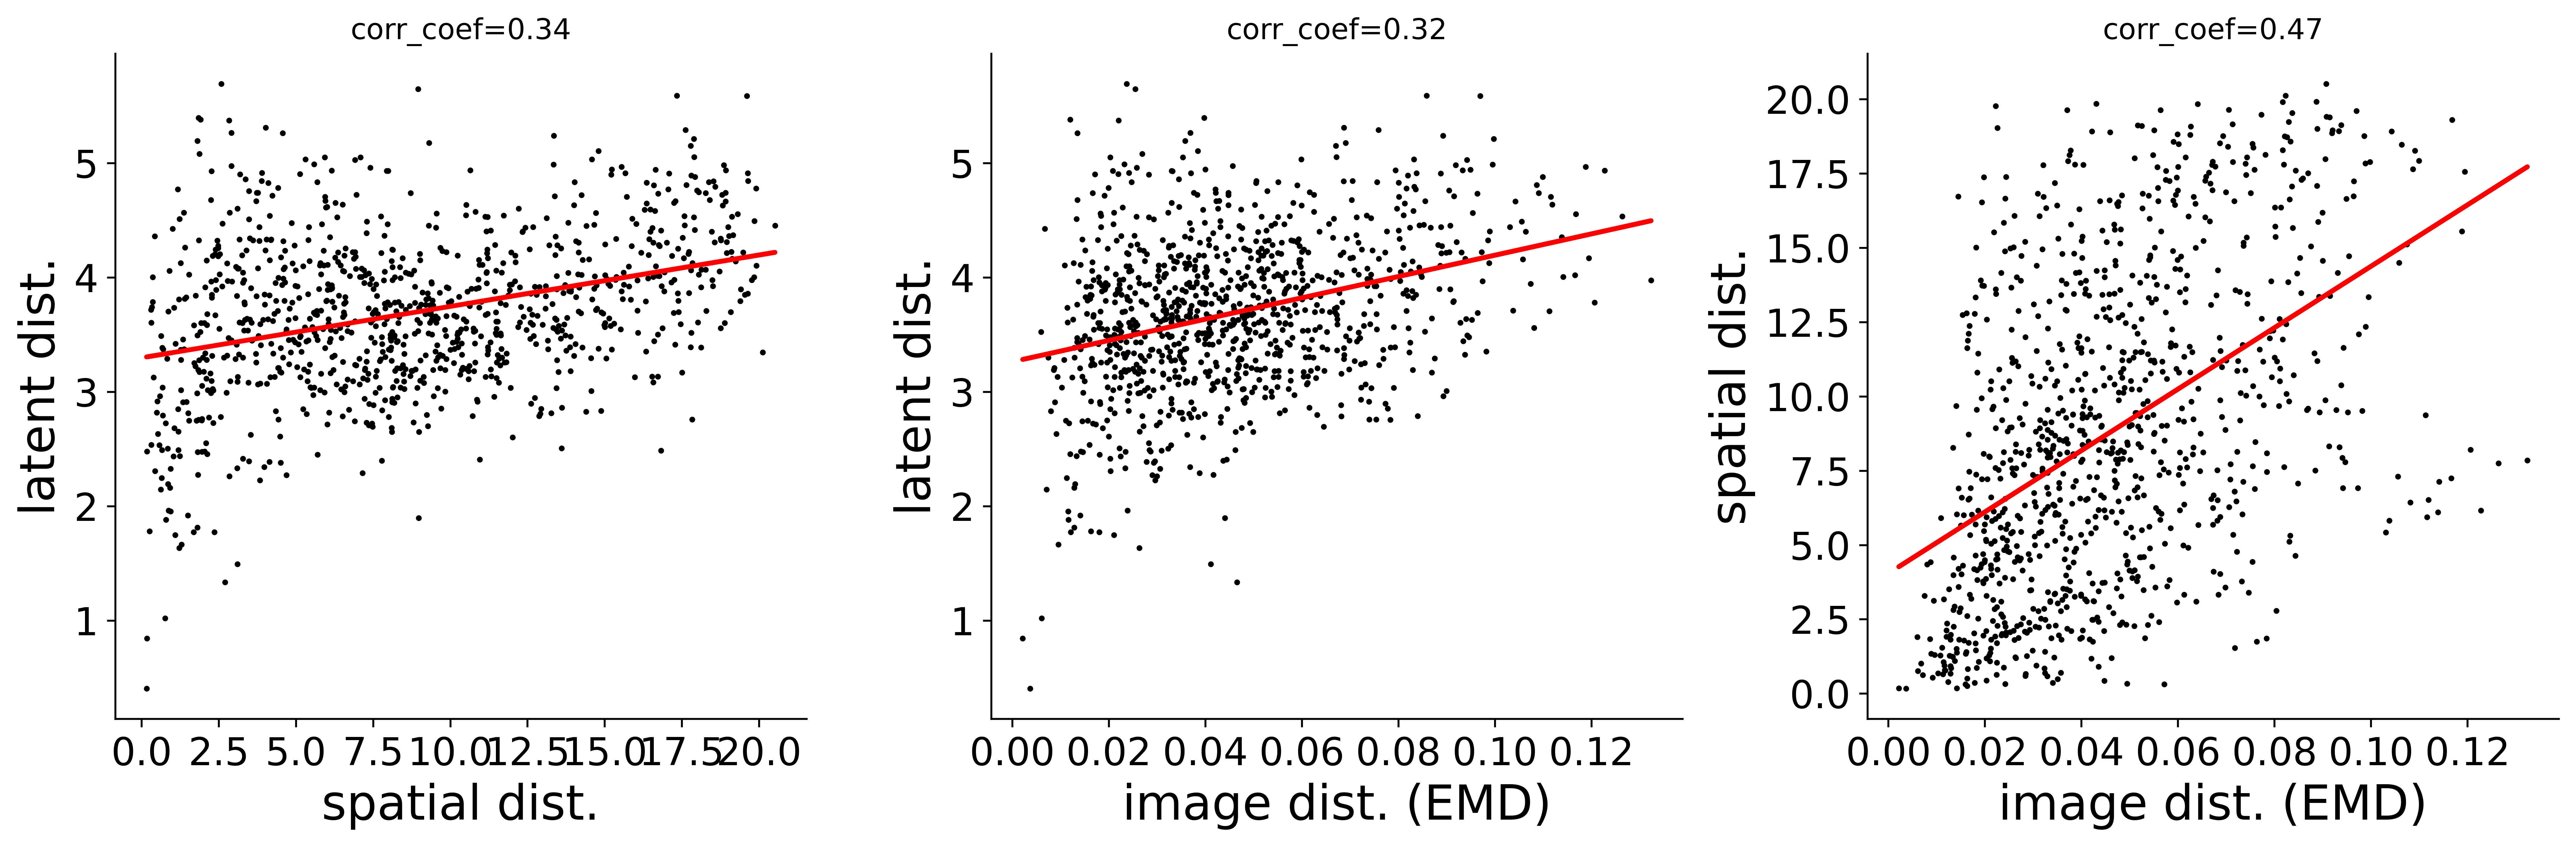

In [32]:
plt.figure(figsize=(15,5), dpi=600)

plt.subplot(131)
plt.scatter(spatial_dist, latent_dist, s=2, color='black')
m,b = np.polyfit(spatial_dist, latent_dist,1)
plt.plot(spatial_dist, m*np.array(spatial_dist)+b, linestyle='-', color='r', linewidth=2)
plt.title('corr_coef='+str(np.corrcoef( spatial_dist, latent_dist )[0][1].round(2)))
plt.ylabel('latent dist.', fontsize=20)
plt.xlabel('spatial dist.', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()

plt.subplot(132)
plt.scatter(image_dist, latent_dist, s=2, color='black')
m,b = np.polyfit(image_dist, latent_dist,1)
plt.plot(image_dist, m*np.array(image_dist)+b, linestyle='-', color='r', linewidth=2)
plt.title('corr_coef='+str(np.corrcoef( image_dist, latent_dist )[0][1].round(2)))
plt.ylabel('latent dist.', fontsize=20)
plt.xlabel('image dist. (EMD)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()

plt.subplot(133)
plt.scatter(image_dist, spatial_dist, s=2, color='black')
m,b = np.polyfit(image_dist, spatial_dist,1)
plt.plot(image_dist, m*np.array(image_dist)+b, linestyle='-', color='r', linewidth=2)
plt.title('corr_coef='+str(np.corrcoef( spatial_dist, image_dist )[0][1].round(2)))
plt.xlabel('image dist. (EMD)', fontsize=20)
plt.ylabel('spatial dist.', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()

plt.tight_layout()
plt.show()

In [33]:
img_dist_time = []
for i in range(n_images):
    d = wasserstein_distance(data[0].flatten(), data[i].flatten())
    img_dist_time.append(d)

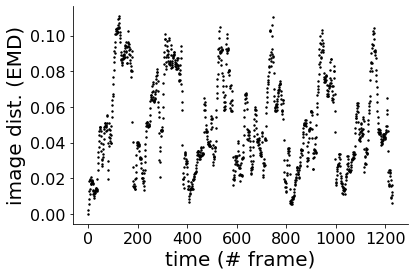

In [34]:
plt.figure(figsize=(6,4))

plt.scatter(range(n_images), img_dist_time, s=2, color='black')
plt.ylabel('image dist. (EMD)', fontsize=20)
plt.xlabel('time (# frame)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.despine()

## Non-AE dimensionality reduction

In [84]:
## EXTRACT LATENT MANIFOLD FROM HIDDEN LAYER RESPONSES

#embedding = MDS(n_components=200)
#embedding = TSNE(n_components=200)
embedding = Isomap(n_components=200)
reduced = embedding.fit_transform(data.reshape((data.shape[0], 476*636)))

In [85]:
reduced.shape

(1385, 200)

In [86]:
ratemaps_all_reduced = generate_ratemaps(reduced)

In [87]:
plt.figure(figsize=(20,40), dpi=600)
for i in range(hidden_layer_size):
    plt.subplot(20, 10, i+1)
    plt.imshow(ratemaps_all_reduced[i], cmap='hot', origin='lower')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [90]:
# Get the place field histogram for the hidden layer
num_fields_reduced = []
for i in range(hidden_layer_size):
    num_fields_reduced.append( get_number_of_place_fields(ratemaps_all_reduced[i]) )
place_field_counts_reduced = np.histogram(num_fields_reduced, bins=np.max(num_fields_reduced)+1, density=True)[0]

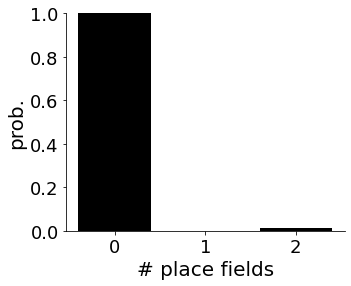

In [91]:
plt.figure(figsize=(5,4))
plt.bar(np.arange(np.max(num_fields_reduced)+1), place_field_counts_reduced, color='black', alpha=1)
plt.xlabel('# place fields', fontsize=20)
plt.ylabel('prob.', fontsize=20)
plt.yticks(np.linspace(0,1,6), np.linspace(0,1,6).round(1), fontsize=18)
plt.xticks(np.linspace(0, np.max(num_fields_reduced), np.max(num_fields_reduced)+1, dtype=int), np.linspace(0, np.max(num_fields_reduced), np.max(num_fields_reduced)+1, dtype=int), fontsize=18)
plt.ylim(0,1)
sns.despine()
plt.show()

In [ ]:
def spatial_info(ratemap):
    '''
    Computes the spatial info/selectivity (in unit of 'bits') contained in a ratemap as the entropy of the neuron's activity 
    across spatial positions.
    '''
    c_ratemap = ratemap.copy()
    r = c_ratemap.flatten()
    if (np.sum(r) > 0):
        prob_r = r/np.sum(r)
        entropy = -np.nansum(prob_r*np.log2(prob_r))
        return entropy
    else:
        return 0